### Exploring 2017 Statcast Data

Goals:
- Learn about what's contained in the Statcast data
- Build a model to predict the result of a hit based on:
    - Launch angles
    - Exit velocity
    - Barrel maybe??
- Simulate how a player would perform on a different team. 
    - Get schedule for new team
    - Randomly assign each hit to a stadium and predict result
    - Calculate new metrics based on results

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

### Data Preparation and Cleaning

In [84]:
sc2017 = pd.read_csv('statcast_2017.csv')

In [3]:
sc2017.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,barrel
0,FF,2017-04-02,93.7,2.7324,6.3169,Randal Grichuk,545341,543557,single,hit_into_play_score,...,4-Seam Fastball,3,3,3,3,3,3,3,3,1.0
1,CU,2017-04-02,80.6,2.8152,6.3348,Randal Grichuk,545341,543557,NaN,ball,...,Curveball,3,3,3,3,3,3,3,3,NaN
2,CU,2017-04-02,77.9,2.9033,6.3019,Randal Grichuk,545341,543557,NaN,called_strike,...,Curveball,3,3,3,3,3,3,3,3,NaN
3,CU,2017-04-02,77.5,2.7517,6.2277,Kolten Wong,543939,543557,walk,blocked_ball,...,Curveball,3,3,3,3,3,3,3,3,NaN
4,FF,2017-04-02,93.1,2.8012,6.2854,Kolten Wong,543939,543557,NaN,foul,...,4-Seam Fastball,3,3,3,3,3,3,3,3,NaN


In [85]:
sc2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724626 entries, 0 to 724625
Data columns (total 88 columns):
pitch_type                         719031 non-null object
game_date                          724626 non-null object
release_speed                      718920 non-null float64
release_pos_x                      718827 non-null float64
release_pos_z                      718827 non-null float64
player_name                        724626 non-null object
batter                             724626 non-null int64
pitcher                            724626 non-null int64
events                             185659 non-null object
description                        724626 non-null object
spin_dir                           0 non-null float64
spin_rate_deprecated               0 non-null float64
break_angle_deprecated             0 non-null float64
break_length_deprecated            0 non-null float64
zone                               718780 non-null float64
des                              

In [11]:
#Check to see if 'events' contains outcomes of the at bat

sc2017['events'].value_counts()

field_out                       73376
strikeout                       39949
single                          26918
walk                            14859
double                           8397
home_run                         6105
grounded_into_double_play        3804
force_out                        3657
hit_by_pitch                     1763
field_error                      1579
sac_fly                          1146
intent_walk                       970
sac_bunt                          925
triple                            795
double_play                       423
fielders_choice_out               308
caught_stealing_2b                203
strikeout_double_play             155
fielders_choice                    93
catcher_interf                     43
other_out                          36
pickoff_caught_stealing_2b         32
pickoff_1b                         30
pickoff_2b                         29
sac_fly_double_play                22
caught_stealing_3b                 19
caught_steal

In [12]:
#Check if 'stand' represents batter handedness

sc2017['stand'].value_counts()

R    424224
L    300402
Name: stand, dtype: int64

### Refining the data

I'm only interested in the batting data, so I'm going to get rid of a lot of the columns related to pitching and game state. One thing that's an issue is that there doesn't appear to be a horizontal launch angle. The columns I'm interested in keeping are:

- player_name
- stand
- events
- home_team
- launch_angle
- launch_speed
- barrel

Before I filter down to just those columns, I'm going to reduce the dataframe to only include rows with a launch angle and launch speed. 

In [94]:
sc2017_batted_ball = sc2017[(pd.notnull(sc2017['launch_angle'])) & (pd.notnull(sc2017['launch_speed']))]

In [95]:
sc2017_batted_ball.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203326 entries, 0 to 724616
Data columns (total 88 columns):
pitch_type                         202923 non-null object
game_date                          203326 non-null object
release_speed                      202886 non-null float64
release_pos_x                      202853 non-null float64
release_pos_z                      202853 non-null float64
player_name                        203326 non-null object
batter                             203326 non-null int64
pitcher                            203326 non-null int64
events                             128219 non-null object
description                        203326 non-null object
spin_dir                           0 non-null float64
spin_rate_deprecated               0 non-null float64
break_angle_deprecated             0 non-null float64
break_length_deprecated            0 non-null float64
zone                               202839 non-null float64
des                              

I also need only cases where I know the outcome, which is in the 'events' column

In [97]:
sc2017_batted_ball = sc2017_batted_ball[pd.notnull(sc2017_batted_ball['events'])]

In [98]:
sc2017_batted_ball.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128219 entries, 0 to 724616
Data columns (total 88 columns):
pitch_type                         127821 non-null object
game_date                          128219 non-null object
release_speed                      127779 non-null float64
release_pos_x                      127748 non-null float64
release_pos_z                      127748 non-null float64
player_name                        128219 non-null object
batter                             128219 non-null int64
pitcher                            128219 non-null int64
events                             128219 non-null object
description                        128219 non-null object
spin_dir                           0 non-null float64
spin_rate_deprecated               0 non-null float64
break_angle_deprecated             0 non-null float64
break_length_deprecated            0 non-null float64
zone                               127737 non-null float64
des                              

In [99]:
sc2017_batted_ball['events'].value_counts()

field_out                     73376
single                        26913
double                         8397
home_run                       6105
grounded_into_double_play      3804
force_out                      3657
field_error                    1579
sac_fly                        1146
sac_bunt                        925
triple                          795
double_play                     423
strikeout                       325
fielders_choice_out             308
hit_by_pitch                    298
fielders_choice                  93
sac_fly_double_play              22
walk                             18
catcher_interf                   12
triple_play                       7
pickoff_1b                        5
pickoff_caught_stealing_2b        4
pickoff_2b                        3
other_out                         2
strikeout_double_play             1
caught_stealing_2b                1
Name: events, dtype: int64

There are some weird situations here where clearly the result is not a batted ball (hbp, walk, pickoff attempts). Those are:

- hit_by_pitch
- walk
- catcher_interf
- pickoff_1b
- pickoff_2b
- pickoff_caught_stealing_2b
- strikeout_double_play
- caught_stealing_2b

I'll remove the rows containing these events

In [101]:
#Define bad events

bad_events = ['hit_by_pitch','walk','catcher_interf','pickoff_1b','pickoff_2b','pickoff_caught_stealing_2b',
              'strikeout_double_play','caught_stealing_2b']

In [124]:
#Drop bad events

def is_bad_event(x, list_of_bad_events):
    if x in list_of_bad_events:
        return True
    else:
        return False

In [128]:
sc2017_batted_ball['drop_col'] = sc2017_batted_ball['events'].apply(lambda x: is_bad_event(x,bad_events))

In [130]:
sc2017_batted_ball = sc2017_batted_ball[sc2017_batted_ball['drop_col'] == False]

In [132]:
#Check to see if this worked

sc2017_batted_ball['events'].value_counts()

field_out                    73376
single                       26913
double                        8397
home_run                      6105
grounded_into_double_play     3804
force_out                     3657
field_error                   1579
sac_fly                       1146
sac_bunt                       925
triple                         795
double_play                    423
strikeout                      325
fielders_choice_out            308
fielders_choice                 93
sac_fly_double_play             22
triple_play                      7
other_out                        2
Name: events, dtype: int64

#### Changing the 'events' labels

I'd like to simplify the 'events' outcomes to [1B, 2B, 3B, HR, OUT]. 

In [133]:
def relabel_event(x):
    if x == 'single':
        return '1B'
    elif x == 'double':
        return '2B'
    elif x == 'triple':
        return '3B'
    elif x == 'home_run':
        return 'HR'
    else:
        return 'OUT'

In [135]:
sc2017_batted_ball['events'] = sc2017_batted_ball['events'].apply(lambda x: relabel_event(x))

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [136]:
sc2017_batted_ball['events'].value_counts()

OUT    85667
1B     26913
2B      8397
HR      6105
3B       795
Name: events, dtype: int64

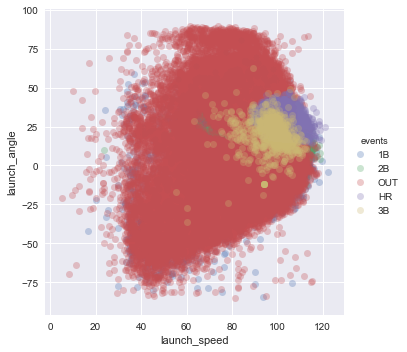

In [142]:
sns.lmplot('launch_speed', 'launch_angle', data = sc2017_batted_ball, hue = 'events', fit_reg = False, 
           scatter_kws={'alpha': 0.3})

### Filtering Columns

Finally, I need to filter to just the columns I'm interested in, which again are:

- player_name
- stand
- events
- home_team
- launch_angle
- launch_speed
- barrel

In [144]:
cols = ['player_name','stand','events','home_team','launch_angle','launch_speed','barrel']

In [147]:
sc2017_batted_ball_filtered = sc2017_batted_ball[cols]

In [148]:
sc2017_batted_ball_filtered.head()

,player_name,stand,events,home_team,launch_angle,launch_speed,barrel
0,Randal Grichuk,R,1B,STL,18.100,109.3,1.0
18,Jose Martinez,R,2B,STL,24.752,104.7,1.0
22,Matt Carpenter,L,OUT,STL,44.199,81.9,0.0
28,Javier Baez,R,OUT,STL,65.349,89.9,0.0
34,Willson Contreras,R,HR,STL,26.617,106.2,1.0


In [149]:
sc2017_batted_ball_filtered.to_csv('sc2017_batted_ball_filtered.csv',index = False)